# Beacon

In [1]:
import cv2
import numpy as np
import math
#import picamera
import io
from IPython.display import Image
import time
import glob
from termcolor import colored
import math
import re
import cv2
import numpy as np
from matplotlib import pyplot as plt
center = (934, 620)

In [2]:
def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

# HSV Filtering

In [4]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
center = (934, 620)
def nothing(x):
    pass
cv2.namedWindow('Colorbars')
hmax='hmax'
hmin='hMin'
smax='sMax'
smin='sMin'
vmax='vMax'
vmin='vMin'

wnd = 'Colorbars'
cv2.createTrackbar("hMax", "Colorbars",0,255,nothing)
cv2.createTrackbar("hMin", "Colorbars",0,255,nothing)
cv2.createTrackbar("sMax", "Colorbars",0,255,nothing)
cv2.createTrackbar("sMin", "Colorbars",0,255,nothing)
cv2.createTrackbar("vMax", "Colorbars",0,255,nothing)
cv2.createTrackbar("vMin", "Colorbars",0,255,nothing)

rawImage = cv2.imread('threshold_img.png') 
rawImage = cv2.cvtColor(rawImage, cv2.COLOR_BGR2HSV)
height,width,depth = rawImage.shape
imgWithCircle  = np.zeros((height,width), np.uint8)
cv2.circle(imgWithCircle,center,400,(255,255,255),thickness=-1)
cv2.circle(imgWithCircle,center,280,(0,0,0),thickness=-1)
imask = imgWithCircle>0
img = np.zeros_like(rawImage, np.uint8)
img[imask] = rawImage[imask]

img = cv2.resize(img, (0,0), fx=0.2, fy=0.2)

# titles = ['Original Image','BINARY','BINARY_INV','TRUNC','TOZERO','TOZERO_INV']
# images = [img, thresh1, thresh2, thresh3, thresh4, thresh5]
# for i in xrange(6):
#     plt.subplot(2,3,i+1),plt.imshow(images[i],'gray')
#     plt.title(titles[i])
#     plt.xticks([]),plt.yticks([])
# plt.show()
while(1):
    hmax=cv2.getTrackbarPos("hmax", "Colorbars")
    hmin=cv2.getTrackbarPos("hMin", "Colorbars")
    smax=cv2.getTrackbarPos("sMax", "Colorbars")
    smin=cv2.getTrackbarPos("sMin", "Colorbars")
    vmax=cv2.getTrackbarPos("vMax", "Colorbars")
    vmin=cv2.getTrackbarPos("vMin", "Colorbars")
    
    lower = np.array((hmin,smin,vmin), dtype = "uint8")
    upper = np.array((hmax,smax,vmax), dtype = "uint8")
 
    # find the colors within the specified boundaries and apply
    # the mask
    mask = cv2.inRange(img, lower, upper)
    output = cv2.bitwise_and(img, img, mask = mask)
    
    # cv2.imshow(wnd)
    cv2.imshow("img",img)
    cv2.imshow("output",output)
    
    k = cv2.waitKey(1) & 0xFF
    if k == ord('m'):
        mode = not mode
    elif k == 27:
        break
cv2.destroyAllWindows()

KeyboardInterrupt: 

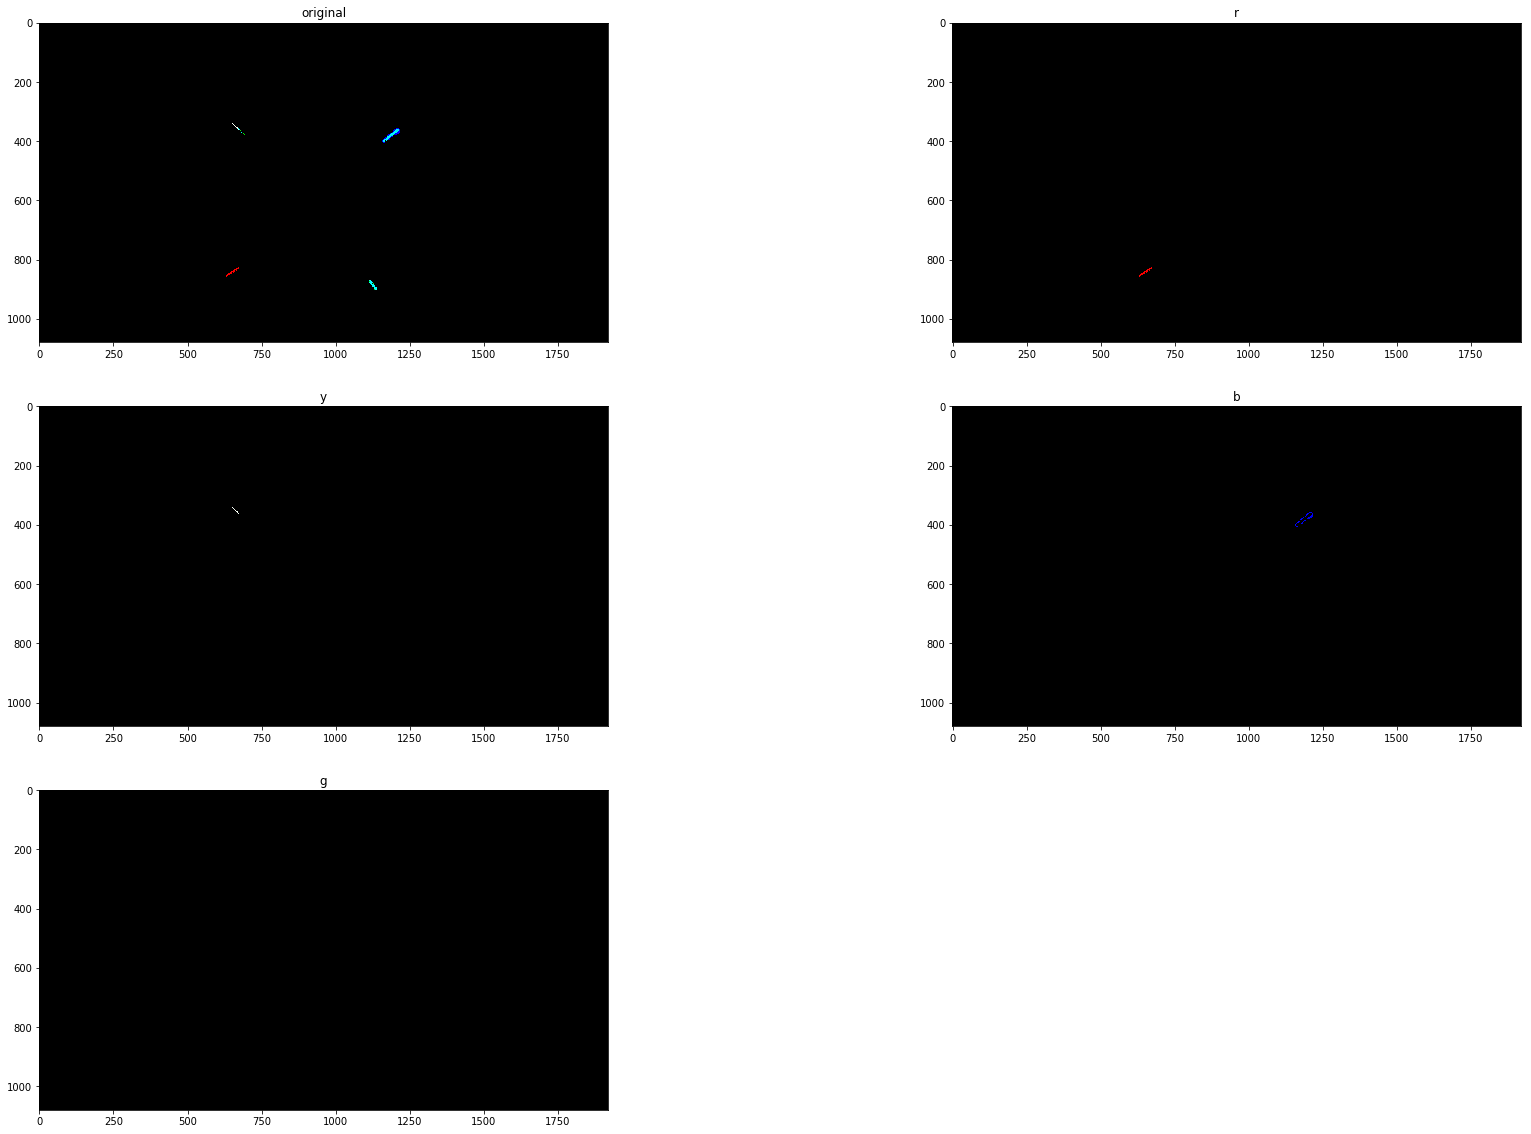

In [6]:
threshImg = cv2.imread('threshold_img.png') 
# define the list of boundaries
boundaries = [
     ([0, 0, 225], [255, 0, 255], 'r'),
     ([26, 0, 26], [255, 255, 255], 'y'),
     ([12, 0, 0], [255, 0, 255], 'b'),
     ([103, 86, 65], [145, 133, 128], 'g')
]
thresh_img = cv2.cvtColor(threshImg, cv2.COLOR_BGR2RGB)
images = [thresh_img]
titles = ['original']
# loop over the boundaries
for (lower, upper, title) in boundaries:
    # create NumPy arrays from the boundaries
    lower = np.array(lower, dtype = "uint8")
    upper = np.array(upper, dtype = "uint8")
 
    # find the colors within the specified boundaries and apply
    # the mask
    mask = cv2.inRange(threshImg, lower, upper)
    output = cv2.bitwise_and(threshImg, threshImg, mask = mask)
 
    # show the images
    output = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
    images.append(output)
    titles.append(title)
show_images(images, cols = 3, titles = titles)

In [4]:
rawImage = cv2.imread('beacon_4500_3500_180.png')    
height,width,depth = rawImage.shape
imgWithCircle  = np.zeros((height,width), np.uint8)
cv2.circle(imgWithCircle,center,400,(255,255,255),thickness=-1)
cv2.circle(imgWithCircle,center,280,(0,0,0),thickness=-1)
imask = imgWithCircle>0
img = np.zeros_like(rawImage, np.uint8)
img[imask] = rawImage[imask]
ret,thresh_img = cv2.threshold(img,232,0,cv2.THRESH_TOZERO)
#thresh_img = cv2.cvtColor(thresh_img, cv2.COLOR_BGR2RGB)
cv2.imwrite('threshold_img.png',thresh_img)

True

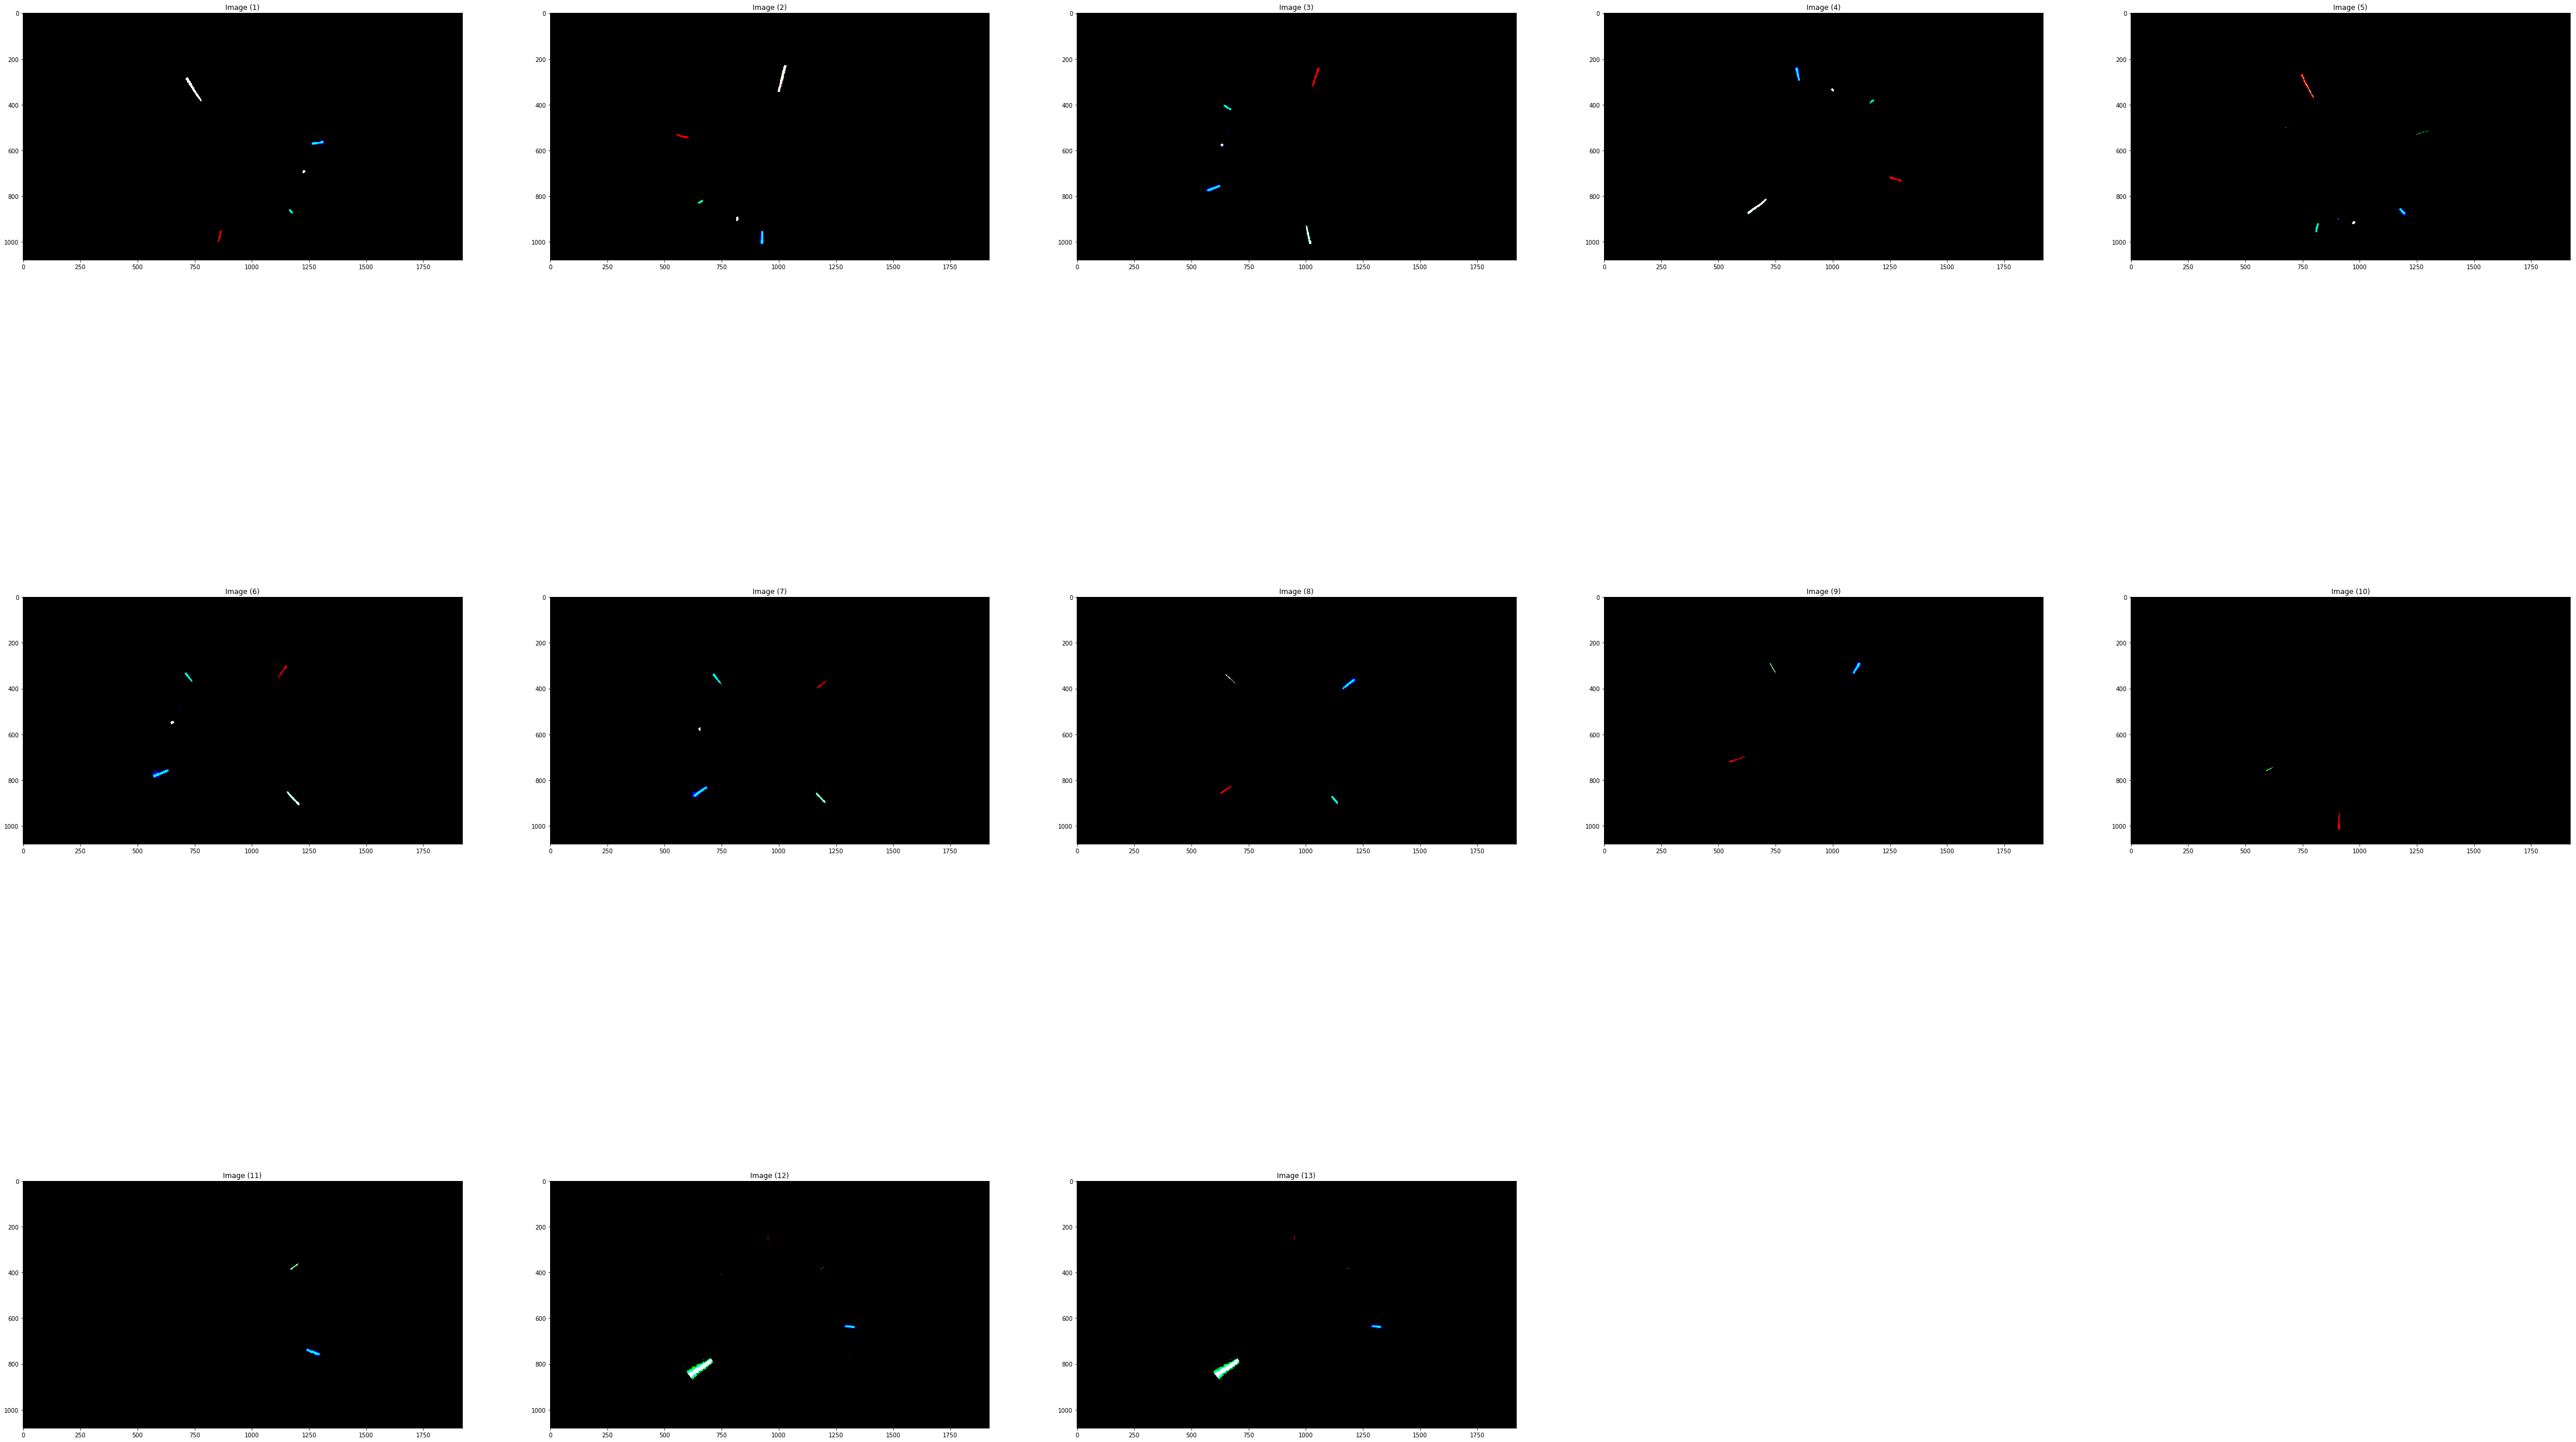

In [12]:
i = 1
images = []
for filename in glob.glob("./*.png"):
    rawImage = cv2.imread(filename)    
    height,width,depth = rawImage.shape
    imgWithCircle  = np.zeros((height,width), np.uint8)
    cv2.circle(imgWithCircle,center,400,(255,255,255),thickness=-1)
    cv2.circle(imgWithCircle,center,280,(0,0,0),thickness=-1)
    imask = imgWithCircle>0
    img = np.zeros_like(rawImage, np.uint8)
    img[imask] = rawImage[imask]
    ret,thresh_img = cv2.threshold(img,232,0,cv2.THRESH_TOZERO)
    thresh_img = cv2.cvtColor(thresh_img, cv2.COLOR_BGR2RGB)
    images.append(thresh_img)
show_images(images, cols = 3, titles = None)

In [14]:

i = 1
for filename in glob.glob("./*.png"):
    print("-- Picture: ", i, '--')
    elements = re.findall('[+-]?\d+', filename)
    print(elements)
    x,y,a = elements[0],elements[1],elements[2]
    x,y,a = float(x),float(y),float(a)
    img = cv2.imread(filename)
    print(get_robot_position(img))
    xb,yb,ab = get_robot_position(img)
    print("position from beacon: ",xb,yb,ab)
    print("real position: ",x,y,a)
    dist = math.sqrt((x-xb)*(x-xb) + (y-yb)*(y-yb))
    print("distance: ", dist)
    if dist > 300 or abs(a-ab) > 5:    
        print(colored('error', 'red'))
    else:
        print(colored('good', 'green'))


    i = i + 1


-- Picture:  1 --
['1000', '1000', '180']
[0, 3]
[0, 3]
Not enought light source
[0, 3]
[0, 3]
Not enought light source
[0, 3]
[0, 3]
Not enought light source
(-1, -1, -1)


C:\Users\antho\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\antho\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[0, 3]
[0, 3]
Not enought light source
[0, 3]
[0, 3]
Not enought light source
[0, 3]
[0, 3]
Not enought light source
position from beacon:  -1 -1 -1
real position:  1000.0 1000.0 180.0
distance:  1415.6277759354682
error
-- Picture:  2 --
['1000', '200', '90']
[0, 1]
[0, 1]
Not enought light source
[0, 1]
[0, 1]
Not enought light source
[0, 1]
[0, 1]
Not enought light source
(-1, -1, -1)
[0, 1]
[0, 1]
Not enought light source
[0, 1]
[0, 1]
Not enought light source
[0, 1]
[0, 1]
Not enought light source
position from beacon:  -1 -1 -1
real position:  1000.0 200.0 90.0
distance:  1020.9809008987387
error
-- Picture:  3 --
['1000', '4000', '0']
[2, 3]
[2, 3]
Not enought light source
[2, 3]
[2, 3]
Not enought light source
[2, 3]
[2, 3]
Not enought light source
(-1, -1, -1)
[2, 3]
[2, 3]
Not enought light source
[2, 3]
[2, 3]
Not enought light source
[2, 3]
[2, 3]
Not enought light source
position from beacon:  -1 -1 -1
real position:  1000.0 4000.0 0.0
distance:  4124.318367924571
error
--

ValueError: not enough values to unpack (expected 3, got 2)

# Finding threshold

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
center = (934, 620)
def nothing(x):
    pass
cv2.namedWindow('Colorbars')
hh='Max'
hl='Min'
wnd = 'Colorbars'
cv2.createTrackbar("Max", "Colorbars",0,255,nothing)
cv2.createTrackbar("Min", "Colorbars",0,255,nothing)

rawImage = cv2.imread('beacon_4500_3500_180.png')

height,width,depth = rawImage.shape
imgWithCircle  = np.zeros((height,width), np.uint8)
cv2.circle(imgWithCircle,center,400,(255,255,255),thickness=-1)
cv2.circle(imgWithCircle,center,280,(0,0,0),thickness=-1)
imask = imgWithCircle>0
img = np.zeros_like(rawImage, np.uint8)
img[imask] = rawImage[imask]

img = cv2.resize(img, (0,0), fx=0.2, fy=0.2)

# titles = ['Original Image','BINARY','BINARY_INV','TRUNC','TOZERO','TOZERO_INV']
# images = [img, thresh1, thresh2, thresh3, thresh4, thresh5]
# for i in xrange(6):
#     plt.subplot(2,3,i+1),plt.imshow(images[i],'gray')
#     plt.title(titles[i])
#     plt.xticks([]),plt.yticks([])
# plt.show()
while(1):
    hul=cv2.getTrackbarPos("Max", "Colorbars")
    huh=cv2.getTrackbarPos("Min", "Colorbars")
    ret,thresh1 = cv2.threshold(img,hul,huh,cv2.THRESH_BINARY)
    ret,thresh2 = cv2.threshold(img,hul,huh,cv2.THRESH_BINARY_INV)
    ret,thresh3 = cv2.threshold(img,hul,huh,cv2.THRESH_TRUNC)
    ret,thresh4 = cv2.threshold(img,hul,huh,cv2.THRESH_TOZERO)
    ret,thresh5 = cv2.threshold(img,hul,huh,cv2.THRESH_TOZERO_INV)
    # cv2.imshow(wnd)
    cv2.imshow("thresh1",thresh1)
    cv2.imshow("thresh2",thresh2)
    cv2.imshow("thresh3",thresh3)
    cv2.imshow("thresh4",thresh4)
    cv2.imshow("thresh5",thresh5)
    
    k = cv2.waitKey(1) & 0xFF
    if k == ord('m'):
        mode = not mode
    elif k == 27:
        break
cv2.destroyAllWindows()

KeyboardInterrupt: 

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
center = (934, 620)
def nothing(x):
    pass
cv2.namedWindow('Colorbars')
hh='Max'
hl='Min'
wnd = 'Colorbars'
cv2.createTrackbar("Max", "Colorbars",0,255,nothing)
cv2.createTrackbar("Min", "Colorbars",0,255,nothing)

rawImage = cv2.imread('beacon_4500_3500_180.png')

height,width,depth = rawImage.shape
imgWithCircle  = np.zeros((height,width), np.uint8)
cv2.circle(imgWithCircle,center,400,(255,255,255),thickness=-1)
cv2.circle(imgWithCircle,center,280,(0,0,0),thickness=-1)
imask = imgWithCircle>0
img = np.zeros_like(rawImage, np.uint8)
img[imask] = rawImage[imask]

img = cv2.resize(img, (0,0), fx=0.2, fy=0.2)

# titles = ['Original Image','BINARY','BINARY_INV','TRUNC','TOZERO','TOZERO_INV']
# images = [img, thresh1, thresh2, thresh3, thresh4, thresh5]
# for i in xrange(6):
#     plt.subplot(2,3,i+1),plt.imshow(images[i],'gray')
#     plt.title(titles[i])
#     plt.xticks([]),plt.yticks([])
# plt.show()
while(1):
    r_max=cv2.getTrackbarPos("r_Max", "Colorbars")
    g_max=cv2.getTrackbarPos("g_Max", "Colorbars")
    b_max=cv2.getTrackbarPos("b_Max", "Colorbars")
    r_min=cv2.getTrackbarPos("r_Min", "Colorbars")
    g_min=cv2.getTrackbarPos("g_Min", "Colorbars")
    b_min=cv2.getTrackbarPos("b_Min", "Colorbars")
    ret,thresh1 = cv2.threshold(img,hul,huh,cv2.THRESH_BINARY)
    ret,thresh2 = cv2.threshold(img,hul,huh,cv2.THRESH_BINARY_INV)
    ret,thresh3 = cv2.threshold(img,hul,huh,cv2.THRESH_TRUNC)
    ret,thresh4 = cv2.threshold(img,hul,huh,cv2.THRESH_TOZERO)
    ret,thresh5 = cv2.threshold(img,hul,huh,cv2.THRESH_TOZERO_INV)
    # cv2.imshow(wnd)
    cv2.imshow("thresh1",thresh1)
    cv2.imshow("thresh2",thresh2)
    cv2.imshow("thresh3",thresh3)
    cv2.imshow("thresh4",thresh4)
    cv2.imshow("thresh5",thresh5)
    
    k = cv2.waitKey(1) & 0xFF
    if k == ord('m'):
        mode = not mode
    elif k == 27:
        break
cv2.destroyAllWindows()

In [ ]:
center_cone_x = 983#981
center_cone_y = 596#597 
RedLed = (0,8040)
GreenLed = (8040,8040)
BlueLed = (8040,0)
YellowLed = (0,0)


g_low = (30, 100, 110)
g_high = (35, 255,255)
b_low = (10, 125, 125)
b_high = (15, 255,255)
r_low = (110, 100, 100)
r_high = (130, 255,255)

y_low = (50,40, 40)
y_high = (90, 255,255)



def Find_center(selection,channel,img,center_cone_x,center_cone_y):

    center_position = [(0,0),(0,0),(0,0),(0,0)]
    color = [(0,255,255,),(0,0,255,),(0,255,0),(255,0,0)]
    # convert the grayscale image to binary image
    for i in selection:
        gray_image = cv2.cvtColor(channel[i], cv2.COLOR_BGR2GRAY)
        gray_image = cv2.GaussianBlur(gray_image,(5,5),1)
        

        
        # find contours in the binary image
        _, contours, _ = cv2.findContours(gray_image,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        c = contours[0]
        # calculate moments for each contour
        M = cv2.moments(c)

        # calculate x,y coordinate of center
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        center_position[i] = (cX,cY)
        cv2.circle(img, (cX, cY), 5, (255, 255, 255), -1)
        cv2.line(img,(cX ,cY),(center_cone_x,center_cone_y),color[i], 2)
     
    cv2.line(img,(center_cone_x +200  ,center_cone_y  ),(center_cone_x,center_cone_y),[255,255,255], 1)
    

    cv2.circle(img, (center_cone_x, center_cone_y), 5, (255, 255, 255), -1)
    return center_position, img




def Extract_channels(img):

    #img = cv2.GaussianBlur(img,(5,5),1)

    ## convert to hsv
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    mask_g = cv2.inRange(hsv,g_low ,g_high )
    mask_b = cv2.inRange(hsv, b_low, b_high)
    mask_r = cv2.inRange(hsv, r_low, r_high)
    mask_y = cv2.inRange(hsv, y_low, y_high)
    
    #gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)


    



    ## slice the green
    imask_r = mask_r>0
    imask_g = mask_g>0
    imask_b = mask_b>0
    imask_y = mask_y>0
  

    green = np.zeros_like(img, np.uint8)
    red = np.zeros_like(img, np.uint8)
    blue = np.zeros_like(img, np.uint8)
    yellow = np.zeros_like(img, np.uint8)


    red[imask_r] = img[imask_r]
    green[imask_g] = img[imask_g]
    blue[imask_b] = img[imask_b]
    yellow[imask_y] = img[imask_y]

    ## save 

    image = np.zeros_like(img, np.uint8)
    image = red + blue +green + yellow
    channel = [yellow, red,green,blue]
    
    return channel , image




def Selecting_channel(channel,r):
    color = [(0,255,255),(255,0,0,),(0,255,0),(0,0,255)]
    selection = []
    position = []
    for i in range(len(channel)):
        
        
        gray_image = cv2.cvtColor(channel[i], cv2.COLOR_BGR2GRAY)
        non_zero = np.nonzero(gray_image)
        l = len(non_zero[0])//2
        if l > 0:
            selection.append(i)
            position = ((non_zero[1][l],non_zero[0][l]))
        
        
    print(selection)    
    if len(selection) == 4 :
        try:
            print("Remove value")
            selection.remove(r)
        except:
            pass
    print(selection)
    return selection #, position






    

def Get_lights_angle(selection, center_position,center_cone_x,center_cone_y ):
    vec = [[0,0],[0,0],[0,0],[0,0]]
    angle = [0,0,0,0]
    
    ref_vector = (200,0) 
    
    ref_norm = math.sqrt(ref_vector[0]*ref_vector[0] + ref_vector[1]*ref_vector[1])
    for i in selection:

        vec[i] = ([center_position[i][0] - center_cone_x , center_position[i][1] - center_cone_y ])
    
        


   
        try:
            
            angle[i]=((math.atan2(ref_vector[1],ref_vector[0]) - math.atan2(vec[i][1],vec[i][0])))
        except:
            pass



    angle = np.array(angle)
    
    #angle = angle[np.nonzero(angle)]

    #RG RB GB


    return angle


def Get_robot_position(selection,angle,Beacon_position):
    #Choose Balise GreenLed as origin
    B = []
    

    for i in selection:
        

        B.append(Beacon_position[i])

    
    
    x1 = B[1][0] - B[0][0] 

    y1 = B[1][1] - B[0][1]


    x3 = B[2][0] - B[0][0]

    y3 = B[2][1] - B[0][1]

    x2 = B[0][0]

    y2 = B[0][1]


    t1 = 1/math.tan((angle[selection[0]] - angle[selection[1]] ))

    t2 = 1/math.tan((angle[selection[2]] - angle[selection[0]]  ))

    t3 = (1-t1*t2)/(t1+t2)

    x12 = x1 + t1*y1
    y12 = y1 - t1*x1

    x23 = x3 - t2*y3
    y23 = y3+t2*x3

    x31 = (x3+x1) + t3*(y3 - y1)
    y31 = (y3 + y1) - t3*(x3-x1)

    

    k31 = x1*x3 + y1*y3 + t3*(x1*y3 - x3*y1)

    D = (x12 - x23 )*(y23 - y31) -(y12 - y23)*(x23 - x31)

    X =  x2 + (k31*(y12 - y23))/D
    Y = y2 + (k31*(x23 - x12))/D

    theta = math.atan2(y2 - Y , x2 - X)  - (angle[selection[0]])
    return X,Y , math.degrees(theta)


def get_robot_position(raw_image):

    raw_image  = cv2.flip( raw_image, 1 )

    Computed_position = []
    Valid_position = []
     
    height,width,depth = raw_image.shape
    circle_img  = np.zeros((height,width), np.uint8)
    
    cv2.circle(circle_img,(center_cone_x,center_cone_y),135,(255,255,255),thickness=-1)
    cv2.circle(circle_img,(center_cone_x,center_cone_y),105,(0,0,0),thickness=-1)
    imask = circle_img>0
    picture = np.zeros_like(raw_image, np.uint8)
    picture[imask] = raw_image[imask]
    

    
    channel,img = Extract_channels(picture)
    cv2.imwrite('channel.jpg', picture)
    for i in range(3):
        selection = Selecting_channel(channel,i)
    
        if len(selection) < 3:
            print("Not enought light source")
            Computed_position.append([-8000,-8000,0])
        else:
            position , img = Find_center(selection,channel,raw_image,center_cone_x,center_cone_y)

            #display(channel,position,img,center_cone_x,center_cone_y , selection)
            cv2.imwrite('photo_beacon_post.jpg', img)

            angle = Get_lights_angle(selection, position,center_cone_x,center_cone_y )
            X ,Y ,A = Get_robot_position(selection,angle,[YellowLed,RedLed,GreenLed,BlueLed])
            Computed_position.append([X,Y,A])
    
            for i in Computed_position:
                if ( i[0]>0 and i[0]< 7999 and i[1]>0 and i[1] <7999):
                    Valid_position.append(i)
                
                    
                    
                    
    #ret = 
    if math.isnan(np.median(Valid_position,axis =0)):
        return -1, -1, -1
    print("not none")
    return np.median(Valid_position,axis =0)
